In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

# %matplotlib inline

from time import time
from operator import itemgetter
from datetime import datetime
from collections import defaultdict
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, LabelEncoder

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import subprocess
import sys
import copy

Populating the interactive namespace from numpy and matplotlib


# Functions

In [2]:
def finish(text=None):
    os.system("paplay /usr/share/sounds/gnome/default/alerts/drip.ogg")
    
    if text:
        os.system("echo " + text + " | festival --tts")
    else:
        os.system("paplay /usr/share/sounds/gnome/default/alerts/glass.ogg")

In [3]:
import subprocess
import sys

In [4]:
bestLogloss = 0.460876581644
def evaluate(model, X, y, string, more = ""):
    title = string + " score: " + more
    score = model.score(X, y)
    scoreLogloss = log_loss(y, model.predict_proba(X))
    
    currentDate = str(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    
    if model.get_params().has_key('forest'):
        modelExplaination = model.get_params()['forest'].__class__.__name__ + str(model.get_params()['forest'].get_params())
    else:
        modelExplaination = model.__class__.__name__  + str(model.get_params())
    
    logline = str(score) + ";" + str(scoreLogloss) + ";" + currentDate + ";" + str(modelExplaination) + ";" + more
    
    with open("evaluate"+string+".log", "a") as myfile:
        myfile.write(logline+"\n")
    
    print title
    print score
    print str(scoreLogloss)  + " compare to best score: " + str(scoreLogloss-bestLogloss) 
    
    finish("Evaluate finished!")

# Load

In [5]:
kaggleTrain = pd.read_csv("kaggle/train.csv", header = 0)
kaggleTest = pd.read_csv("kaggle/test.csv", header = 0)

In [6]:
print "Kaggle Train count: " + str(len(kaggleTrain))
print "Kaggle Test count:  " + str(len(kaggleTest))

Kaggle Train count: 114321
Kaggle Test count:  114393


## Columns listing

In [7]:
#print train.schema.fields
columnsDict = {}
columnsDict = defaultdict(lambda: list(), columnsDict)
for col in kaggleTrain.columns:
    typeKey = str(kaggleTrain[col].dtype)
    colName = col
    
    if colName == 'ID':
        print "We have the ID columns, type: " + typeKey
        continue
    if colName == 'target':
        print "We have the target columns, type: " + typeKey
        continue
        
    if typeKey == "object":
        if len(kaggleTrain[col].unique()) < 9 : # Because v71 has 9 distinct value and some missing in the testing set
            columnsDict['dummies'].append(colName)
            continue # Dummies should not be added
            

    columnsDict[typeKey].append(colName)

print ""
for ct, cl in columnsDict.iteritems():
    print ct + " " + str(len(cl))

We have the ID columns, type: int64
We have the target columns, type: int64

dummies 10
int64 4
object 9
float64 108


In [8]:
# Add dummies
kaggleTrainDummies = pd.get_dummies(kaggleTrain[columnsDict['dummies']])
kaggleTrain = pd.concat([kaggleTrain, kaggleTrainDummies], axis=1)

kaggleTestDummies = pd.get_dummies(kaggleTest[columnsDict['dummies']])
kaggleTest = pd.concat([kaggleTest, kaggleTestDummies], axis=1)

In [9]:
print set(kaggleTrainDummies.columns) - set(kaggleTestDummies.columns)
print set(kaggleTestDummies.columns) - set(kaggleTrainDummies.columns)
print set(kaggleTrain.columns) - set(kaggleTest.columns)

set([])
set([])
set(['target'])


In [10]:
columnsDict['dummies']

['v3', 'v24', 'v30', 'v31', 'v66', 'v74', 'v75', 'v91', 'v107', 'v110']

# Split

In [11]:
train, test = train_test_split(kaggleTrain, test_size = 0.2)

In [12]:
train[columnsDict['object']].apply(pd.Series.nunique)

v22     16640
v47        10
v52        12
v56       115
v71         8
v79        18
v112       22
v113       35
v125       90
dtype: int64

# Prepare X and y

In [13]:
print len(columnsDict['float64']) +  len(columnsDict['int64'])

112


In [14]:
catEncoders = dict()
catProbability = dict()
nbrTestMissing = dict()
nbrTestMissing = defaultdict(lambda: {"nbrMissing": 0, 'nbrDistinct': 0}, nbrTestMissing)
# Create the mapping from categorie to int
for col in columnsDict['object']:
    # Create dictionnary
    uniqueValues = kaggleTrain[col].unique()
    dictValues = dict()
    dictValues = defaultdict(lambda: -1, dictValues)       
    for v in uniqueValues:
        if v is nan:
            continue
        if not v in dictValues:
            dictValues[v] = len(dictValues)
    dictValues[nan] = -1
    
    
    # Cat probability
    df = pd.pivot_table(kaggleTrain, values='target', columns=[col], aggfunc=np.average) # index=['A', 'B']
    dictProba = df.to_dict()
    #dictProba = defaultdict(lambda: -1, dictProba)
    
    # If value is in the training but not in the testing, then map to missing -1
    uniqueValuesTesting = kaggleTest[col].unique()
    for v in set(uniqueValuesTesting) - set(uniqueValues):
        dictValues[v] = -1
        dictProba[v] = -1
        nbrTestMissing[col] = {"nbrMissing": nbrTestMissing[col]['nbrMissing'] + 1, 'nbrDistinct': len(uniqueValues)}

    catEncoders[col] = dictValues
    catProbability[col] = dictProba
print "Number of missing value per column in the Testing set"
print nbrTestMissing

Number of missing value per column in the Testing set
defaultdict(<function <lambda> at 0x7f2b18628aa0>, {'v56': {'nbrMissing': 8, 'nbrDistinct': 123}, 'v22': {'nbrMissing': 5209, 'nbrDistinct': 18211}, 'v71': {'nbrMissing': 3, 'nbrDistinct': 9}, 'v113': {'nbrMissing': 1, 'nbrDistinct': 37}})


In [15]:
print catEncoders['v56']
#print catProbability

defaultdict(<function <lambda> at 0x7f2b165fb398>, {'BD': 57, 'BE': 94, 'BF': 74, 'BG': 61, 'BA': 33, nan: -1, 'BC': 88, 'BL': 19, 'BM': 14, 'BN': 112, 'BO': 117, 'BH': 59, 'BI': 58, 'BJ': 16, 'BK': 37, 'BT': 119, 'BU': 24, 'BV': 17, 'BW': 3, 'BP': 96, 'BQ': 13, 'BR': 92, 'BS': 34, 'BX': 35, 'BY': 83, 'BZ': 27, 'Z': 11, 'BB': -1, 'D': 120, 'H': 51, 'L': 111, 'P': 25, 'T': 114, 'X': 106, 'A': 47, 'AE': 99, 'I': 97, 'C': 62, 'G': 40, 'M': 108, 'K': -1, 'O': 102, 'S': -1, 'W': 75, 'AQ': -1, 'AU': 77, 'AY': 80, 'CK': 93, 'CJ': 98, 'CI': 39, 'CH': 60, 'CO': 38, 'CN': 20, 'CM': 48, 'F': 78, 'CC': 41, 'CB': 79, 'CA': 63, 'J': -1, 'CG': 105, 'CF': 54, 'CE': 113, 'N': 22, 'CZ': 103, 'CY': 7, 'R': 18, 'V': 23, 'CS': 52, 'CR': -1, 'CQ': 72, 'CP': 56, 'CW': 91, 'CV': 66, 'CU': -1, 'CT': 81, 'CD': 115, 'DN': 12, 'DO': 26, 'DL': 28, 'DM': 42, 'DJ': 32, 'DK': 68, 'DH': 31, 'DI': 0, 'DF': 30, 'DG': 67, 'DD': 118, 'DE': 71, 'DB': 104, 'DC': 121, 'DA': 45, 'B': 82, 'DZ': 36, 'DX': 4, 'DY': 1, 'DV': 95, 

In [16]:
# Choose Encoder or Proba
catForEncoders = []#['v22']#['v22', 'v56']
catEncoders = { your_key: catEncoders[your_key] for your_key in catForEncoders }
catProbability = { your_key: catProbability[your_key] for your_key in set(catProbability.keys()) - set(catForEncoders) }
print catProbability.keys()

['v22', 'v79', 'v71', 'v112', 'v113', 'v125', 'v56', 'v52', 'v47']


In [17]:
def prepareX(df, isTrainning):
    colsToAdd = columnsDict['float64'] + columnsDict['int64']
    
    dfX = df[colsToAdd]
    dfX = dfX.fillna(-1) # -1 is a good missing value encoder because everything is >= 0
    
    for col in colsToAdd:
        dfX[col+"_m"] = df[col]
        
    # Add categorical features, and replace categories with int
    dfX[columnsDict['object']] = df[columnsDict['object']]
    #dfX = dfX.replace(catEncoders) # catEncoders
    #dfX = dfX.replace(catProbability) # catProbability
    # Replace NaN for catProbability
    replaceNan = dict()
    for col in catProbability:
        replaceNan[col] = {NaN: -1}
    dfX = dfX.replace(replaceNan)
    
    # Add dummies
    dfX[kaggleTrainDummies.columns] = df[kaggleTrainDummies.columns]
    
    # Features selection
    if True:
        featToKeep = ['v50', 'v66', 'v113', 'v47', 'v110', 'v10', 'v31', 'v129', 'v12', 'v79', 'v56', 'v14', 'v62', 'v114_m', 'v34_m', 'v40_m', 'v21_m', 'v24', 'v38_m', 'v22', 'v125', 'v72_m', 'v123_m', 'v88_m', 'v28_m', 'v82_m', 'v58_m', 'v100_m', 'v68_m', 'v131', 'v1_m', 'v124_m', 'v45_m', 'v46', 'v37_m', 'v119_m', 'v89_m', 'v98_m', 'v36', 'v85_m', 'v120_m', 'v5_m', 'v16', 'v54_m', 'v35', 'v63_m', 'v6_m', 'v78_m', 'v99_m', 'v126_m', 'v112', 'v97_m', 'v94', 'v122_m', 'v57_m', 'v117_m', 'v2_m', 'v86_m', 'v51_m', 'v84_m', 'v11_m', 'v4_m', 'v130_m', 'v42', 'v18_m', 'v53_m', 'v115_m', 'v118', 'v101_m', 'v9_m', 'v61_m', 'v103_m', 'v127_m', 'v87_m', 'v8_m', 'v7_m', 'v32_m', 'v90_m', 'v81_m', 'v59_m', 'v27_m', 'v128_m', 'v20_m', 'v26_m', 'v105_m', 'v108_m', 'v30', 'v73_m', 'v13_m', 'v102_m', 'v25_m', 'v52', 'v121_m', 'v93_m', 'v41', 'v69_m', 'v95_m', 'v104_m', 'v116_m', 'v80_m', 'v111_m', 'v15_m', 'v43_m', 'v70_m', 'v55_m', 'v106_m', 'v60_m', 'v39_m', 'v19_m', 'v33_m', 'v83_m', 'v76_m', 'v44_m', 'v77_m', 'v48_m', 'v65_m', 'v109_m', 'v67_m', 'v29_m', 'v17_m', 'v49_m', 'v92_m', 'v23', 'v96_m', 'v64_m', 'v71', 'v3', 'v107', 'v91', 'v74', 'v75']
        featToKeep = ['v50_m', 'v56', 'v66', 'v12_m', 'v114_m', 'v10_m', 'v34', 'v40', 'v66_C', 'v14', 'v79', 'v21_m', 'v22', 'v47', 'v125', 'v110', 'v110_B', 'v66_B', 'v31', 'v113', 'v110_A', 'v31_A', 'v112', 'v66_A', 'v52', 'v129', 'v62', 'v24', 'v24_E', 'v31_B', 'v107', 'v91', 'v30', 'v82_m', 'v115_m', 'v88_m', 'v6_m', 'v120_m', 'v119_m', 'v69_m', 'v124_m', 'v102_m', 'v24_D', 'v90', 'v57_m', 'v68_m', 'v1_m', 'v78_m', 'v99_m', 'v45_m', 'v16_m', 'v28_m', 'v126_m', 'missing', 'v100', 'v87', 'v131_m', 'v98_m', 'v70_m', 'v36', 'v39_m', 'v108', 'v37_m', 'v81', 'v53_m', 'v85_m', 'v117_m', 'v58_m', 'v32', 'v27_m', 'v19_m', 'v122_m', 'v44_m', 'v42_m', 'v86_m', 'v7_m', 'v127_m', 'v11_m', 'v55_m', 'v9_m', 'v18_m', 'v103_m', 'v2_m', 'v123_m', 'v109_m', 'v80_m', 'v54_m', 'v25_m', 'v26', 'v73_m', 'v15_m', 'v97_m', 'v63_m', 'v20_m', 'v4_m', 'v89_m', 'v35_m', 'v118_m', 'v94_m', 'v5_m', 'v8_m', 'v116_m', 'v46_m', 'v104_m', 'v83', 'v49', 'v111_m', 'v105_m', 'v51', 'v59_m', 'v43_m', 'v13_m', 'v95_m', 'v128_m', 'v84_m', 'v60_m', 'v101_m', 'v61_m', 'v130_m', 'v121_m', 'v92_m', 'v77_m', 'v24_C', 'v67_m', 'v65_m', 'v33_m', 'v76', 'v93_m', 'v41_m', 'v29_m', 'v96_m', 'v48_m', 'v17_m', 'v106_m', 'v71', 'v64_m', 'v72_m', 'v75', 'v75_D', 'v75_B', 'v30_C', 'v23', 'v91_A', 'v107_E', 'v107_B', 'v107_C', 'v91_G', 'v38', 'v91_B', 'v107_D', 'v91_C', 'v31_C', 'v91_F', 'v107_A', 'v24_B', 'v3', 'v30_G', 'v74_B', 'v74', 'v30_D', 'v3_C', 'v110_C', 'v24_A', 'v74_C', 'v30_E', 'v107_F', 'v91_E', 'v30_F', 'v30_A', 'v3_A', 'v91_D', 'v3_B', 'v30_B', 'v107_G', 'v75_C', 'v75_A', 'v74_A']
        featToKeep = featToKeep[:len(featToKeep)-50] # Remove the last 50 less important feature
        featToKeep = [x for x in featToKeep if x not in columnsDict['dummies']] # Remove dummy columns
        featToKeep = [x for x in featToKeep if x in dfX.columns] # Remove unknow columns
        #featToKeep = featToKeep + kaggleTrainDummies.columns.tolist() # Add dummies columns
        dfX = dfX[featToKeep]
    
    # Features creation:
    dfX['missing'] = df.isnull().sum(axis=1)
    
    finish("Prepare X finished!")
    return dfX

In [18]:
def prepareY(df):   
    return df[["target"]].values.ravel()

In [19]:
X_train = prepareX(train, True)
y_train = prepareY(train)

In [20]:
X_test = prepareX(test, False)
y_test = prepareY(test)

In [21]:
colsMissingValues = X_train.isnull().sum()
print "Nbr columns train: " + str(len(train.columns))
print "Nbr columns train prepared: " + str(len(X_train.columns))
print len(X_test.columns)
#print set(train.columns) - set(X_train.columns)
print len(colsMissingValues)

Nbr columns train: 178
Nbr columns train prepared: 120
120
120


# Model 1 - Stacking
TODO = Cross Validation ?

In [22]:
stacking = False

In [23]:
if stacking:
    X_m1_train, X_m2_train, y_m1_train, y_m2_train = train_test_split(X_train, y_train, test_size = 0.5)

In [24]:
if stacking:
    import imputerproba
    reload(imputerproba)
    from imputerproba import ImputerProba
    model1 = ImputerProba(columnsEncod=[],
                          columnsProba=catProbability.keys(),
                          verbose=1)

In [25]:
if stacking:
    model1All = copy.deepcopy(model1)
    model1All.fit(X_train, y_train)
    X_m2_test = model1All.transform(X_test)
else:
    X_m2_test = X_test

In [26]:
if stacking:
    model1.fit(X_m1_train, y_m1_train)

In [27]:
if stacking:
    X_m2_train = model1.transform(X_m2_train)
else:
    X_m2_train = X_train
    y_m2_train = y_train

# Model

In [28]:
sqrtNbrFeat = int(sqrt(len(X_m2_train.columns)))
print sqrtNbrFeat

10


In [29]:
#.setNumTrees(150).setMaxDepth(6)
rmf = RandomForestClassifier(n_estimators=150,
                             n_jobs=-1,
                             max_depth=10,
                             #max_features=sqrtNbrFeat,
                             criterion='gini') #  max_depth=7

In [ ]:
gbc = GradientBoostingClassifier()

In [ ]:
clf = gbc # rmf etc


In [30]:
#clf.fit(X_m2_train, y_train)

# Pipeline

In [31]:
imputer = Imputer(missing_values="NaN",
                  strategy="mean",
                  axis=0)

In [32]:
catProbability.keys()

['v22', 'v79', 'v71', 'v112', 'v113', 'v125', 'v56', 'v52', 'v47']

In [47]:
import imputerproba
reload(imputerproba)
from imputerproba import ImputerProba
imputerProba = ImputerProba(columnsEncod=(catEncoders.keys() + [x+'_m' for x in catEncoders.keys()]),
                            columnsProba=catProbability.keys(), # If Stacking True : []
                            verbose=1,
                            leaveOneOut=True
                           )

In [48]:
len(X_m2_train)

91456

In [49]:
estimator = Pipeline([("imputerProba", imputerProba),
                      ("imputer", imputer),
                      ("forest", clf)
                     ])

In [50]:
estimator.fit(X_m2_train, y_m2_train)
finish()

fit_transform, lengh X: 91456
Fit, lengh X: 91456
Column proba: v71 is not in X, skip.
Transform, training: True  leaveOneOut: True
Column proba: v71 is not in X, skip.
Index([u'v50_m', u'v56', u'v12_m', u'v114_m', u'v10_m', u'v34', u'v40',
       u'v66_C', u'v14', u'v79', 
       ...
       u'v130_m', u'v121_m', u'v92_m', u'v77_m', u'v24_C', u'v67_m', u'v65_m',
       u'v33_m', u'v76', u'missing'],
      dtype='object', length=120)


## Scoring

In [51]:
evaluate(estimator, X_m2_train, y_m2_train, "Training", "estimator+missingFeat+dummy")

Transform, training: False  leaveOneOut: True
Column proba: v71 is not in X, skip.
Index([u'v50_m', u'v56', u'v12_m', u'v114_m', u'v10_m', u'v34', u'v40',
       u'v66_C', u'v14', u'v79', 
       ...
       u'v130_m', u'v121_m', u'v92_m', u'v77_m', u'v24_C', u'v67_m', u'v65_m',
       u'v33_m', u'v76', u'missing'],
      dtype='object', length=120)
Transform, training: False  leaveOneOut: True
Column proba: v71 is not in X, skip.
Index([u'v50_m', u'v56', u'v12_m', u'v114_m', u'v10_m', u'v34', u'v40',
       u'v66_C', u'v14', u'v79', 
       ...
       u'v130_m', u'v121_m', u'v92_m', u'v77_m', u'v24_C', u'v67_m', u'v65_m',
       u'v33_m', u'v76', u'missing'],
      dtype='object', length=120)
Training score: estimator+missingFeat+dummy
0.761371588523
0.539602661471 compare to best score: 0.0787260798271


In [52]:
evaluate(estimator, X_m2_test, y_test, "Testing", "estimator+missingFeat+dummy")

Transform, training: False  leaveOneOut: True
Column proba: v71 is not in X, skip.
Index([u'v50_m', u'v56', u'v12_m', u'v114_m', u'v10_m', u'v34', u'v40',
       u'v66_C', u'v14', u'v79', 
       ...
       u'v130_m', u'v121_m', u'v92_m', u'v77_m', u'v24_C', u'v67_m', u'v65_m',
       u'v33_m', u'v76', u'missing'],
      dtype='object', length=120)
Transform, training: False  leaveOneOut: True
Column proba: v71 is not in X, skip.
Index([u'v50_m', u'v56', u'v12_m', u'v114_m', u'v10_m', u'v34', u'v40',
       u'v66_C', u'v14', u'v79', 
       ...
       u'v130_m', u'v121_m', u'v92_m', u'v77_m', u'v24_C', u'v67_m', u'v65_m',
       u'v33_m', u'v76', u'missing'],
      dtype='object', length=120)
Testing score: estimator+missingFeat+dummy
0.763831183031
0.546563410313 compare to best score: 0.0856868286693


## Features Analysis

In [55]:
featToKeep = []
def feature_analysis(model, X):
    importancePd = pd.DataFrame(X.columns, columns=["feature"])
    importancePd["importance"] = model.feature_importances_
    
    importancePd = importancePd.sort(['importance'], ascending=[0])
    importancePd = importancePd.set_index(['feature'])
    
    print importancePd.head(n=10)

    plt.figure();
    pylab.rcParams['figure.figsize'] = (30, 3)
    importancePd[:50].plot(kind='bar');
    importancePd[50:200].plot(kind='bar');
    plt.axhline(0, color='k')
           
    featToKeep = []
    for index, row in importancePd.iterrows():
        #print row['importance']
        #print index
        
        if not "_m" in index:
            indexWithM = index + "_m"
            if index not in importancePd.columns:
                continue
            imp = importancePd[importancePd.index==index].importance.item()
            impWithM = importancePd[importancePd.index==indexWithM]
            if len(impWithM):
                impWithM = impWithM.importance.item()
            
                if impWithM <= imp:
                    #print index + " is better        impNotM: " + str(impWithM) + " <= imp: " + str(imp)
                    featToKeep.append(index)
                else:
                    #print indexWithM + " is better   impNotM: " + str(impWithM) + " > imp: " + str(imp)
                    featToKeep.append(indexWithM)
            else:
                featToKeep.append(index)
                
    print "Features to keep (use only if all the features are here from prepareX):"
    print featToKeep
    

         importance
feature            
v47        0.374801
v79        0.190223
v113       0.071020
v56        0.054755
v112       0.047562
v52        0.045130
v50_m      0.039070
v110_B     0.021777
v110_A     0.019416
v31_A      0.011665
Features to keep (use only if all the features are here from prepareX):
[]


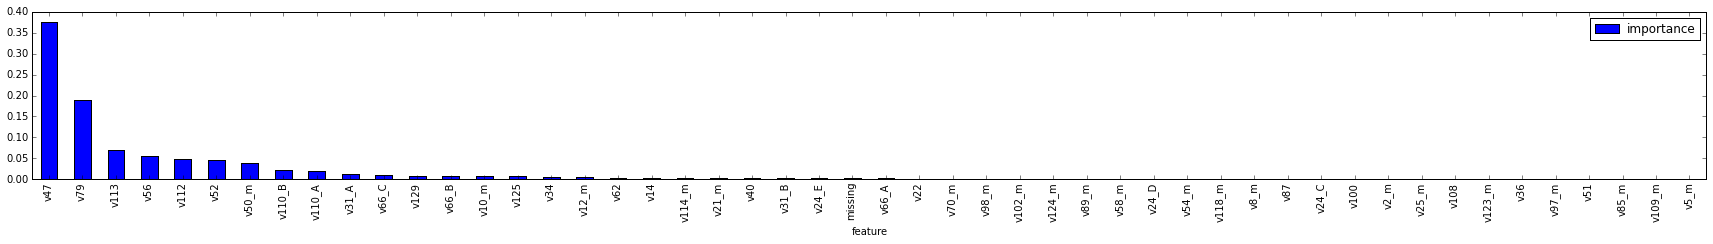

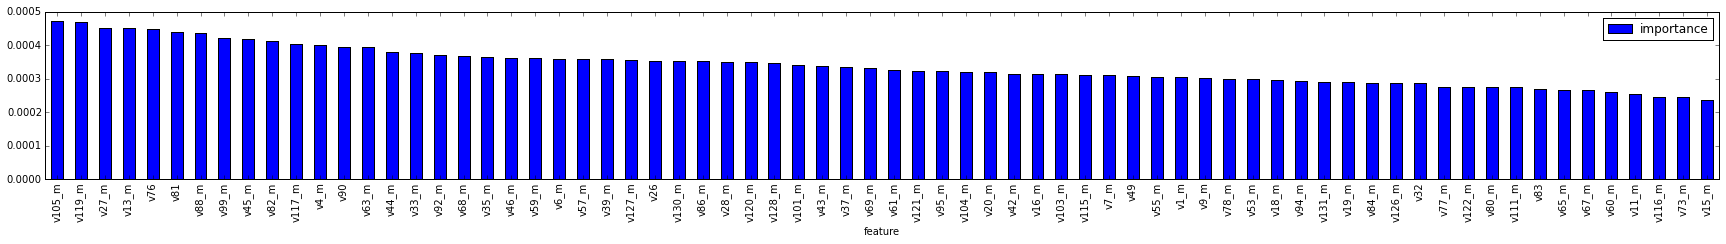

In [56]:
feature_analysis(clf, X_m2_train)

# Grid search

In [57]:
# Utility function to report best scores
def report(grid_scores, n_top=3, save=False):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")
        
        if save:
            currentDate = str(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
            logline = str("{0}".format(i + 1)) + ";" + "{0:.5f};{1:.5f}".format(score.mean_validation_score,np.std(score.cv_validation_scores)) + ";" + currentDate + ";" + "{0}".format(score.parameters)
            with open("gridSearch.log", "a") as myfile:
                myfile.write(logline+"\n")

In [58]:
# specify parameters and distributions to sample from
modelName = "forest__"
param_dist = {modelName+"max_depth": [None],          # Default -> None | If Nonen then nodes are expanded until min_samples_split (Ignored if max_leaf_nodes is not None.)
              modelName+"max_features": sp_randint(sqrtNbrFeat-4, sqrtNbrFeat+4),#sp_randint(14, 24),      # Default -> sqrt(n_features) ~14
              modelName+"min_samples_split": sp_randint(1, 5), # Default -> 2 (useless if mex_depth not None)
              modelName+"min_samples_leaf": sp_randint(1, 15),  # Default -> 1
              modelName+"bootstrap": [False]              # Default -> True
              #modelName+"criterion": ["gini", "entropy"] # gini
             }

# run randomized search
n_iter_search = 20
grid_search = RandomizedSearchCV(estimator, param_distributions=param_dist,
                                   n_iter=n_iter_search, scoring="log_loss")

In [ ]:
start = time()
grid_search.fit(X_m2_train, y_m2_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(grid_search.grid_scores_)
finish()

Index([u'v50_m', u'v56', u'v12_m', u'v114_m', u'v10_m', u'v34', u'v40',
       u'v66_C', u'v14', u'v79', 
       ...
       u'v130_m', u'v121_m', u'v92_m', u'v77_m', u'v24_C', u'v67_m', u'v65_m',
       u'v33_m', u'v76', u'missing'],
      dtype='object', length=120)
Index([u'v50_m', u'v56', u'v12_m', u'v114_m', u'v10_m', u'v34', u'v40',
       u'v66_C', u'v14', u'v79', 
       ...
       u'v130_m', u'v121_m', u'v92_m', u'v77_m', u'v24_C', u'v67_m', u'v65_m',
       u'v33_m', u'v76', u'missing'],
      dtype='object', length=120)
Index([u'v50_m', u'v56', u'v12_m', u'v114_m', u'v10_m', u'v34', u'v40',
       u'v66_C', u'v14', u'v79', 
       ...
       u'v130_m', u'v121_m', u'v92_m', u'v77_m', u'v24_C', u'v67_m', u'v65_m',
       u'v33_m', u'v76', u'missing'],
      dtype='object', length=120)
Index([u'v50_m', u'v56', u'v12_m', u'v114_m', u'v10_m', u'v34', u'v40',
       u'v66_C', u'v14', u'v79', 
       ...
       u'v130_m', u'v121_m', u'v92_m', u'v77_m', u'v24_C', u'v67_m', u'v65_m',


In [ ]:
report(grid_search.grid_scores_, 20, True)

### Scoring and Importance

In [ ]:
evaluate(grid_search.best_estimator_, X_m2_test, y_test, "Testing", "GridSearchBest")

In [ ]:
feature_analysis(grid_search.best_estimator_.steps[2][1], X_m2_train)

# Save

In [ ]:
modelToSave = estimator
modelToSave = grid_search.best_estimator_

In [ ]:
X_kaggleTest = prepareX(kaggleTest, False)
print "Nbr columns kaggleTest: " + str(len(kaggleTest.columns))
print "Nbr columns kaggleTest prepared: " + str(len(X_kaggleTest.columns))

In [ ]:
some_value = 'QFA'
for col, typ in X_m2_test.dtypes.iteritems():
    if typ == object:
        df = X_kaggleTest.loc[X_kaggleTest[col] == some_value]
        with pd.option_context('display.max_rows', 10, 'display.max_columns', 200):
            print df

In [ ]:
X_m1_kaggleTest = model1All.transform(X_kaggleTest)

In [ ]:
set(X_m2_test.columns) - set(X_m1_kaggleTest.columns)

In [ ]:
predic = modelToSave.predict_proba(X_m1_kaggleTest)[:,1] # extract 2nd column for X=1

In [ ]:
predicPd = pd.DataFrame(predic)
predicPd = predicPd.rename(columns={0: 'PredictedProb'})
predicPd['ID'] = kaggleTest[['ID']]
predicPd = predicPd[['ID', 'PredictedProb']]

In [ ]:
predicPd.to_csv("results/pythonpure/results.csv", index = False)